In [1]:
import numpy as np
import sigmf
import scipy
import matplotlib.pyplot as plt
from py3gpp import *

In [2]:
handle = sigmf.sigmffile.fromfile('30720KSPS_dl_signal.sigmf-data')
f = 1
mu = 0
apply_fine_CFO = 0

waveform = handle.read_samples()
waveform /= max(waveform.real.max(), waveform.imag.max()) # scale max amplitude to 1
fs = handle.get_global_field(sigmf.SigMFFile.SAMPLE_RATE_KEY)

In [3]:
# SC polar decoder can decode this when repeated bits in nrRateMatchPolar() are used
noise = ((np.random.rand(waveform.shape[0]) - 0.5) + 1j*(np.random.rand(waveform.shape[0]) - 0.5))*1.1
SNR = 10*np.log10((np.linalg.norm(waveform) / np.linalg.norm(noise)))
waveform += noise
print(f'SNR = {SNR} dB')

SNR = -3.1575901294069975 dB


detected NID2 is 2


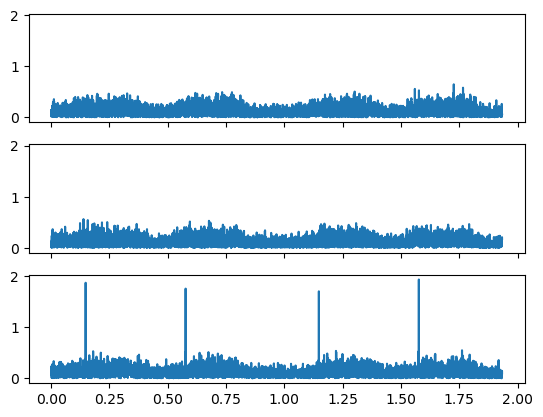

In [6]:
carrier = nrCarrierConfig(NSizeGrid = 106, SubcarrierSpacing = 15 * 2**mu)
info = nrOFDMInfo(carrier)
Nfft = info['Nfft']

peak_value = np.zeros(3)
peak_index = np.zeros(3, 'int')
pssIndices = np.arange((635-63), (635+64))
fig, axs = plt.subplots(3, 1, facecolor='w', sharex=True, sharey=True)
for current_NID2 in np.arange(3, dtype='int'):
    slotGrid = nrResourceGrid(carrier)
    slotGrid = slotGrid[:, 0]
    slotGrid[pssIndices] = nrPSS(current_NID2)
    [refWaveform, info] = nrOFDMModulate(carrier, slotGrid, SampleRate = fs)
    refWaveform = refWaveform[info['CyclicPrefixLengths'][0]:]; # remove CP

    temp = scipy.signal.correlate(waveform[:int(2e-3 * fs)], refWaveform, 'valid')  # correlate over 2 ms
    peak_index[current_NID2] = np.argmax(np.abs(temp))
    peak_value[current_NID2] = np.abs(temp[peak_index[current_NID2]])
    t_corr = np.arange(temp.shape[0])/fs*1e3
    axs[current_NID2].plot(t_corr, np.abs(temp))
detected_NID2 = np.argmax(peak_value)
print(f'detected NID2 is {detected_NID2}')

detected NID2 is 2
max correlation is 397798.8632273853 at 412


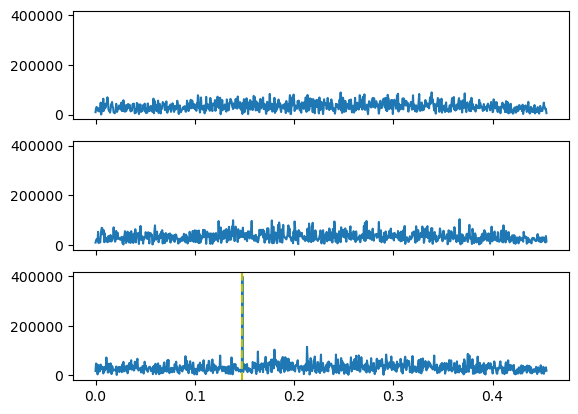

In [5]:
# optimized correlation with decimation, performed with integers

dec_factor = 16
waveform2 = scipy.signal.decimate(waveform, dec_factor, ftype='fir')
waveform2 /= max(waveform2.real.max(), waveform2.imag.max())
waveform2 *= 2**7
waveform2 = waveform2.real.astype(int) + 1j*waveform2.imag.astype(int)

peak_value = np.zeros(3)
peak_index = np.zeros(3, 'int')
fig, axs = plt.subplots(3, 1, facecolor='w', sharex=True, sharey=True)
for current_NID2 in np.arange(3, dtype='int'):
    PSS = np.zeros(128, 'complex')
    PSS[0:-1] = nrPSS(current_NID2)
    refWaveform = np.fft.ifft(np.fft.fftshift(PSS))
    refWaveform /= max(refWaveform.real.max(), refWaveform.imag.max())
    refWaveform *= 2**7
    refWaveform = refWaveform.real.astype(int) + 1j*refWaveform.imag.astype(int)
    temp = scipy.signal.correlate(waveform2[:1000], refWaveform, 'valid')  # correlate over 1000 samples
    peak_index[current_NID2] = np.argmax(np.abs(temp))
    peak_value[current_NID2] = np.abs(temp[peak_index[current_NID2]])
    t_corr = np.arange(temp.shape[0])/(fs/dec_factor)*1e3
    axs[current_NID2].plot(t_corr, np.abs(temp))
detected_NID2 = np.argmax(peak_value)

axs[detected_NID2].axvline(x = t_corr[peak_index[detected_NID2]], color = 'y', linestyle = '--', label = 'axvline - full height')
print(f'detected NID2 is {detected_NID2}')
print(f'max correlation is {peak_value[detected_NID2]} at {peak_index[detected_NID2] + 128}')